In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
from sklearn.cross_validation import train_test_split
from theano import shared
import theano.tensor as T
from pymc3 import *
import warnings
warnings.filterwarnings('ignore')

In [136]:
df = pd.read_csv('breast-cancer-wisconsin.csv')
df['class']=(df['class']-2)/2
df.tail()

# Convert '?' to NaN
df[df == '?'] = np.nan
# Print the number of NaNs
print(df.isnull().sum())


id                         0
clump_thickness            0
unif_cell_size             0
unif_cell_shape            0
marg_adhesion              0
single_epith_cell_size     0
bare_nuclei               16
bland_chrom                0
norm_nucleoli              0
mitoses                    0
class                      0
dtype: int64


In [123]:
#Importing dataset

df = pd.read_csv('breast-cancer-wisconsin.csv')
df.drop(['id'],1,inplace=True)
#df.replace('?',3,inplace=True)

##IMP NOTE: I basically dropped 'bare_nuclei' bcuz of 16 "?" values
X = scale(np.array(df.drop(['class','bare_nuclei'],1)))
y = np.array(df['class'])

#Split Data
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2, random_state=42)

#Sharedvariable
model_input = shared(X_tr)
model_output= shared(y_tr)

In [131]:
#Generate Model
logistic_model = pm.Model()
with logistic_model:
    # Priors for unknown model parameters    
    alpha = pm.Normal("alpha", mu=0,sd=1, shape=(1))
    betas = pm.Normal("betas", mu=0, sd=1, shape=(1,X.shape[1]))
    
    # Expected value of outcome
    p = pm.invlogit(alpha + T.sum(model_input*betas),1)

    # Likelihood (sampling distribution of observations)
    y = pm.Bernoulli('y', p, observed=model_output)

In [159]:
#infering parameters
with logistic_model:
    advi=pm.ADVI()
    approx = advi.fit(n=1000,more_replacements={
        model_input:pm.Minibatch(X_tr),
        model_output:pm.Minibatch(y_tr)
    
     }
        )

Average Loss = inf: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.19it/s]
Finished [100%]: Average Loss = nan


Average Loss = inf: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.87it/s]
Finished [100%]: Average Loss = nan


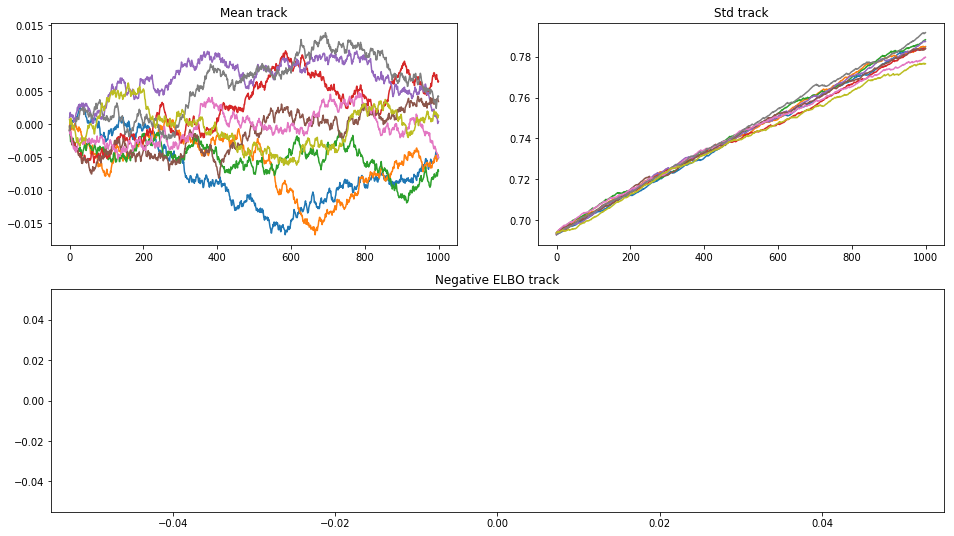

In [158]:
with logistic_model:

    advi=pm.ADVI()
    advi.approx.mean.eval()
    advi.approx.std.eval()

    tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
    )
    approx = advi.fit(1000, callbacks=[tracker])
    
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

In [133]:
for RV in logistic_model.basic_RVs:
    print(RV.name, RV.logp(linear_model.test_point))

alpha -0.9189385332046727
betas -7.351508265637381
y -inf


                mean        sd  mc_error   hpd_2.5  hpd_97.5
alpha__0    0.006183  0.792029  0.011264 -1.390974  1.754659
betas__0_0  0.007540  0.798803  0.010769 -1.522382  1.559579
betas__0_1  0.027156  0.803114  0.011538 -1.646190  1.503577
betas__0_2 -0.002289  0.795141  0.011766 -1.524569  1.560833
betas__0_3  0.004476  0.780805  0.009887 -1.525345  1.536796
betas__0_4 -0.004479  0.779413  0.011065 -1.462173  1.544156
betas__0_5  0.014153  0.786518  0.010239 -1.519242  1.583147
betas__0_6  0.020195  0.788554  0.010790 -1.541064  1.505757
betas__0_7  0.000994  0.784706  0.010757 -1.604608  1.437476


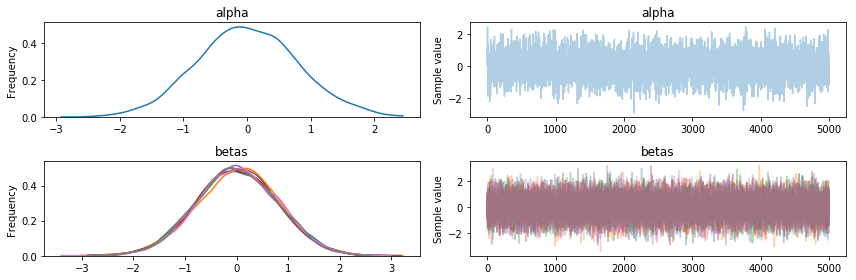

In [137]:
#Intrepreting parameters
trace = approx.sample(draws=5000)
print(pm.summary(trace))

pm.plots.traceplot(trace)
plt.show()

In [141]:
#Replace shared variable with testing set
model_input.set_value(X_te)
model_output.set_value(y_te)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace,model=logistic_model,samples=500)

pred = ppc['y'].mean(axis=0) > 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1315.46it/s]


In [140]:
print('Accuracy = {}%'.format((y_te == pred).mean()*100))

Accuracy = 0.0%
